In [148]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer, auc

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm
from sklearn.utils import resample


# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning as dc

RANDOM = 0
figure_path = "../figures/TNM_outcome/"

### Load datasets 

In [149]:
df1 = pd.read_csv("../data/processed/NCDB_with_growth_complete.csv")
df2 = pd.read_csv("../data/processed/NCDB_without_growth_complete.csv")
II_imputed_df1 = pd.read_csv("../data/processed/NCDB_with_growth_IterativeImputed.csv")
II_imputed_df2 = pd.read_csv("../data/processed/NCDB_without_growth_IterativeImputed.csv")

### Define preprocessing
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)
- standard scale (zscore) numeric, continuous features
- apply KNN imputation! 

In [150]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size']

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features)],
    remainder = 'passthrough')

preproc_basic = Pipeline(steps = [('preproc', preprocessor)])

### Train model, with calibration and cross-validation

In [151]:
# define CV folds                                                       
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
# define logisic reg
LR_model = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'l1', 
                               C = 10,
                              solver = 'liblinear', 
                             random_state = 0)

# add extra step of calibration 
Isotonic = CalibratedClassifierCV(LR_model, method = "isotonic", cv = CV_folds)

Sigmoid = CalibratedClassifierCV(LR_model, method = "sigmoid", cv = CV_folds)

# define scores to get from each model 
def get_scores(y_test, y_pred):
        scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                          "accuracy", "f1 score", "pr_auc", "brier_score"],
                                "scores" : [precision_score(y_test, y_pred), 
                                           recall_score(y_test, y_pred),
                                            roc_auc_score(y_test, y_pred),
                                            accuracy_score(y_test, y_pred),
                                           f1_score(y_test, y_pred), 
                                           average_precision_score(y_test, y_pred), 
                                           brier_score_loss (y_test, y_pred)]
                               })
        scores['scores'] = scores.scores.round(3)
        return (scores)


In [152]:
from sklearn.model_selection import cross_validate
datasets = [df1, df2, II_imputed_df1, II_imputed_df2]
data_names = ['df1_complete', 'df2_complete', 'df1_imputed', 'df2_imputed']

model_choices = [LR_model, Isotonic, Sigmoid]
model_names = ['LR', 'Isotonic', 'Sigmoid']

cv_results = pd.DataFrame()
i = 0
for data in datasets:
    j = 0
    features = data.drop(columns= 'TNM_negative')
    outcome = data['TNM_negative']
    # split into train and test set 
    X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                                  outcome,
                                                                  stratify =outcome,
                                                                  test_size = 0.25, 
                                                                 random_state = 10)
        # further split so only doing CV on the training, validattion for ccalibration
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                         y_trainval,
                                                         stratify = y_trainval, 
                                                         test_size = 0.30, 
                                                         random_state = 10)
    print(data_names[i])
    print("Training N: %0.f" % len(X_train))
    print("Validation N: %0.f" % len(X_test))
    print("Test N: %0.f" % len(X_test))

    # preproc by hand beccause pipeline doesn't wrk with calibrated classifier      
    X_train_preproc = preproc_basic.fit_transform(X_train)

    for model in model_choices:
        print(model_names[j])
        results =  cross_validate(model, X_train_preproc, y_train,
                                      scoring=['precision', 'brier_score_loss', 'recall'], 
                                       cv=CV_folds, n_jobs=-1)
        results = pd.DataFrame(results)
        # get the mean across CV folds
        results_mean = pd.DataFrame(results.mean()).T
        results_mean['dataset'] = data_names[i]
        results_mean['model'] = model_names[j]
        cv_results = pd.concat([cv_results, results_mean], ignore_index = True)
        j = j + 1 # counter for modell names
    i = i + 1 # counter for data names



df1_complete
Training N: 350
Validation N: 168
Test N: 168
LR
Isotonic
Sigmoid
df2_complete
Training N: 648
Validation N: 309
Test N: 309
LR
Isotonic
Sigmoid
df1_imputed
Training N: 1515
Validation N: 722
Test N: 722
LR
Isotonic
Sigmoid
df2_imputed
Training N: 3255
Validation N: 1551
Test N: 1551
LR
Isotonic
Sigmoid


In [153]:
cv_results

,fit_time,score_time,test_precision,test_brier_score_loss,test_recall,dataset,model
0,0.002171,0.003282,0.798429,-0.231920,0.632344,df1_complete,LR
1,0.067352,0.016459,0.724396,-0.201126,0.918924,df1_complete,Isotonic
2,0.072893,0.010900,0.708356,-0.198294,0.969184,df1_complete,Sigmoid
3,0.001936,0.002951,0.794957,-0.243187,0.637829,df2_complete,LR
4,0.057655,0.015859,0.748612,-0.189323,0.974293,df2_complete,Isotonic
5,0.074694,0.011810,0.743181,-0.187919,0.996680,df2_complete,Sigmoid
6,0.003536,0.003641,0.805882,-0.234697,0.662208,df1_imputed,LR
7,0.079889,0.019738,0.731717,-0.188328,0.987884,df1_imputed,Isotonic
8,0.099855,0.012851,0.731936,-0.189167,0.987524,df1_imputed,Sigmoid
9,0.004347,0.003531,0.864614,-0.222999,0.804841,df2_imputed,LR


In [84]:
cv_results[abs(cv_results.test_brier_score_loss) == abs(cv_results.test_brier_score_loss).min()]

,fit_time,score_time,test_precision,test_brier_score_loss,test_recall,dataset,model
10,0.094672,0.020673,0.817307,-0.141828,0.992746,df2_imputed,Isotonic


### Best model on validation set
- Isotonic calibration with df2 imputation data

In [157]:
# define data 
data = df1
features = data.drop(columns= 'TNM_negative')
outcome = data['TNM_negative']
    # split into train and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                                  outcome,
                                                                  stratify =outcome,
                                                                  test_size = 0.25, 
                                                                 random_state = 10)
        # further split so only doing CV on the training, validattion for ccalibration
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                         y_trainval,
                                                         stratify = y_trainval, 
                                                         test_size = 0.30, 
                                                         random_state = 10)
X_train_preproc = preproc_basic.fit_transform(X_train)
X_val_preproc = preproc_basic.fit_transform(X_val)
X_test_preproc = preproc_basic.fit_transform(X_test)
# make predictions

LR_model.fit(X_train_preproc, y_train)
LR_y_val_probs = LR_model.predict_proba(X_val_preproc)[:,1]
LR_y_val_pred = LR_model.predict(X_val_preproc)

Isotonic = CalibratedClassifierCV(LR_model, method = "isotonic", cv =  'prefit')
Isotonic.fit(X_train_preproc, y_train)
Isotonic_y_val_probs = Isotonic.predict_proba(X_val_preproc)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val_preproc)

Sigmoid = CalibratedClassifierCV(LR_model, method = 'sigmoid', cv = 'prefit')
Sigmoid.fit(X_train_preproc, y_train)
Sigmoid_y_val_probs = Sigmoid.predict_proba(X_val_preproc)[:,1]
Sigmoid_y_val_pred = Sigmoid.predict(X_val_preproc)


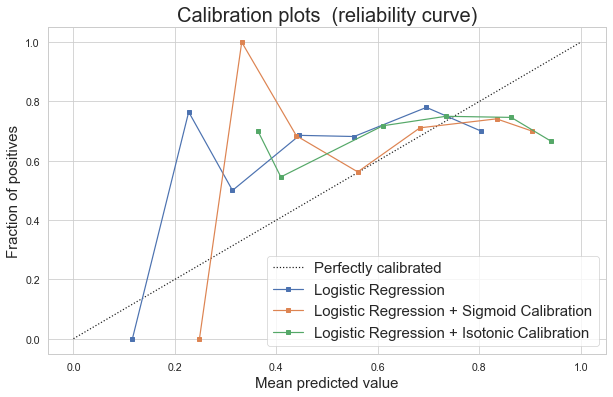

In [158]:

#figure_path = "NCDB_5_features/"
fig = plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, LR_y_val_probs, n_bins =8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Sigmoid_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Sigmoid Calibration")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Isotonic_y_val_probs, n_bins = 8)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Isotonic Calibration")

plt.xlabel("Mean predicted value", size = 15)
plt.ylabel("Fraction of positives", size = 15)
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", fontsize = 15)
plt.title('Calibration plots  (reliability curve)', size = 20)
plt.savefig(os.path.join(figure_path, "Calibration_validation_plot.png"))

### Results with regular model, default threshold


array([[24, 21],
       [45, 61]])

,metrics,scores
0,precision,0.744
1,recall,0.575
2,roc_auc,0.554
3,accuracy,0.563
4,f1 score,0.649
5,pr_auc,0.726
6,brier_score,0.437


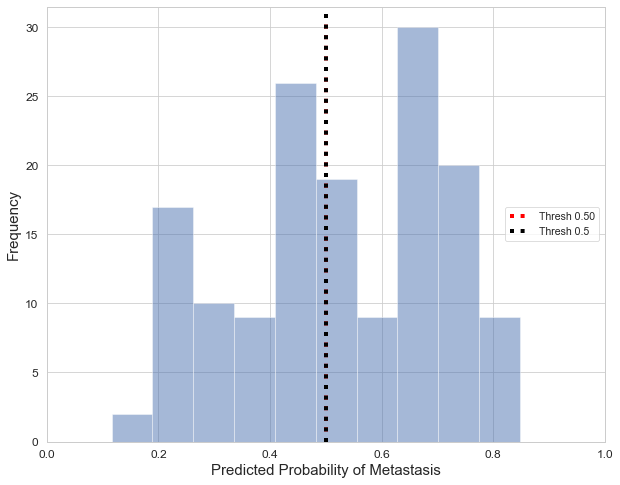

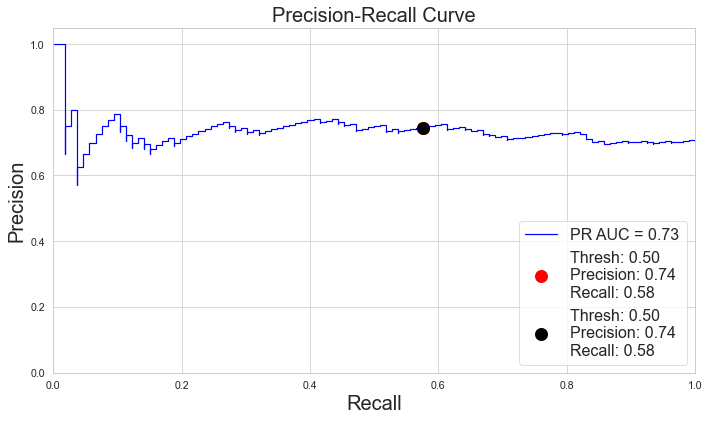

In [159]:

cm = confusion_matrix(y_val, LR_y_val_pred)
display(cm)
LR_val_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
display(LR_val_scores)

custom_plots.plot_predprobs(LR_y_val_probs, 0.5, 
                             filename = os.path.join(figure_path, "LR_predprobs.png"))
custom_plots.plot_pr_curve(y_val, LR_y_val_probs, 0.5,
               filename = os.path.join(figure_path,"LR_validation_PR_curve.png"))



### Results with isotonic calibrated model, default threshold

In [160]:
Isotonic_y_val_probs = Isotonic.predict_proba(X_val_preproc)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val_preproc)

cm = confusion_matrix(y_val, Isotonic_y_val_pred)
display(cm)
val_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
display(val_scores)

print("Range of probabilities: %0.3f - %0.3f" % (min(Isotonic_y_val_probs), max(Isotonic_y_val_probs)))

array([[13, 32],
       [19, 87]])

,metrics,scores
0,precision,0.731
1,recall,0.821
2,roc_auc,0.555
3,accuracy,0.662
4,f1 score,0.773
5,pr_auc,0.726
6,brier_score,0.338


Range of probabilities: 0.364 - 1.000


### results with calibrated model, adjusted threshold

array([[25, 20],
       [51, 55]])

,metrics,scores
0,precision,0.733
1,recall,0.519
2,roc_auc,0.537
3,accuracy,0.530
4,f1 score,0.608
5,pr_auc,0.718
6,brier_score,0.470


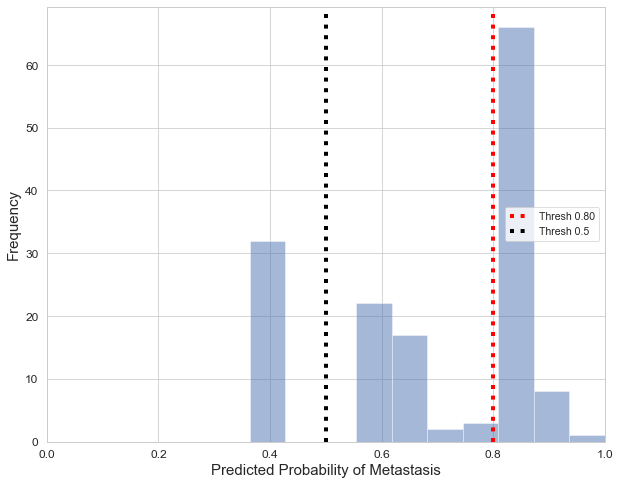

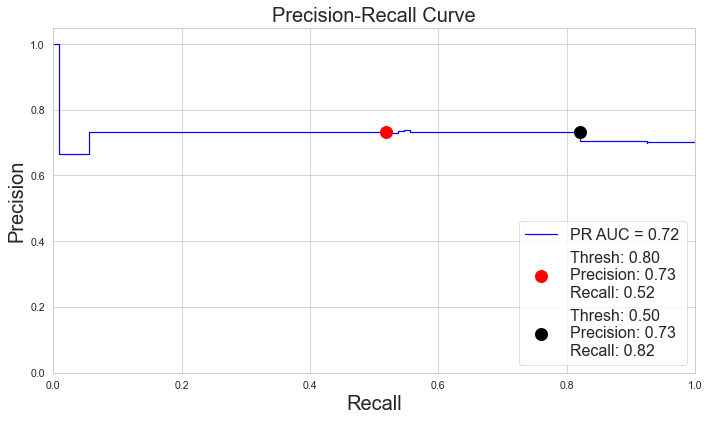

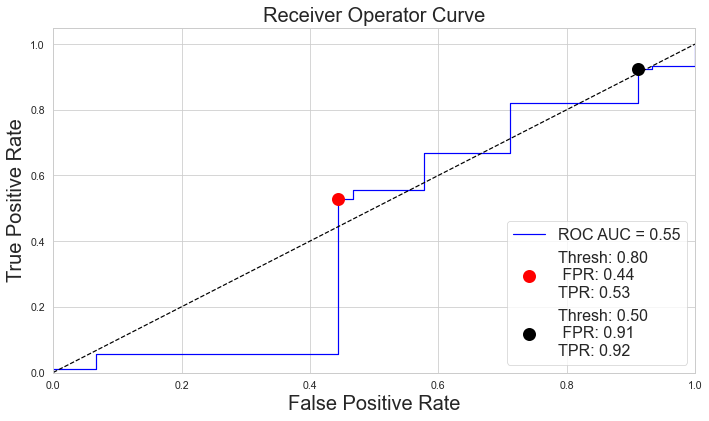

In [161]:
key_thresh = 0.8

Isotonic_y_val_pred_adjusted =  Isotonic_y_val_probs > key_thresh
cm = confusion_matrix(y_val, Isotonic_y_val_pred_adjusted)
display(cm)
val_scores_adjusted = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred_adjusted))
display(val_scores_adjusted)

custom_plots.plot_predprobs(Isotonic_y_val_probs, key_thresh, 
                             filename = os.path.join(figure_path, "predprobs.png"))
custom_plots.plot_pr_curve(y_val, Isotonic_y_val_probs, key_thresh,
               filename = os.path.join(figure_path,"validation_PR_curve.png"))
custom_plots.plot_roc_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_ROC_curve.png"))

### obtain feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.
- preprocessor changes order of variables

In [134]:

# get new feature order frorm preprocessor
preproc_feature_order = pd.DataFrame(modeling.get_feature_names(preprocessor))
preproc_feature_order.columns = ['variable']
preproc_feature_order['num'] = np.arange(start = 0, stop = 9, step = 1).astype('str')
preproc_feature_order['blah'] = 'x'
preproc_feature_order['index'] = preproc_feature_order.blah.str.cat(preproc_feature_order.num, sep = "")


../mcc_metastasis/modeling.py:157: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


### Get feature importance of model from training set
- using bootstrap resampling to get empirical quantiles for 95% CI 
- not using parametric estimates from SE, because w non-parametric bootstrap, inflated estimates... 


In [154]:
# use data frrom your training sample, need to combine to match the X and Y together
X_train_df = pd.DataFrame(X_train).reset_index(drop = True)
y_train_df = pd.DataFrame(y_train).reset_index(drop = True)
data = pd.concat([X_train_df, y_train_df], axis = 1)
# set up lloop 
n_iterations = 100
n_size = int(data.shape[0])
print("Training sample size for bootstrap: %0.f" % n_size)

Training sample size for bootstrap: 1515


In [155]:
# run bootstrap
stats = pd.DataFrame()
for i in range(n_iterations):
    # prepare boostrap sample with resampling, and make sure you stratify!
    train = resample(data, n_samples = n_size, replace = True, stratify = data['TNM_negative'])
    X_train_boot = pd.DataFrame(train.iloc[:, :-1],  columns = X_train_df.columns)
    y_train_boot = train.iloc[:, -1] # last collumns

    # get out-of-bag estimates to test, find rows that weren't included in the train sample
    test = np.array([x for x in data.to_numpy() if x.tolist() not in train.to_numpy().tolist()])
    X_test_boot = pd.DataFrame(test[:, :-1],  columns = X_train_df.columns)
    y_test_boot = pd.DataFrame(test[:, -1]).astype('float') # last column 
    
    # apply preprocessing to your bootstrap sample
    preproc_X_train_boot = preproc_basic.fit_transform(X_train_boot)
    # fit model
    model = LR_model
    model.fit(preproc_X_train_boot, y_train_boot)

    
    #print(classification_report(y_test_boot, y_pred_boot))
    coefs = pd.DataFrame(model.coef_.T)
    stats = pd.concat([stats, coefs], axis = 1)


KeyboardInterrupt: 

In [80]:
# calculate CI 
upper_CI_q = pd.DataFrame()
lower_CI_q = pd.DataFrame()

for i in range(stats.shape[0]):
   # print(i)
    coef_row = stats.iloc[i, :]
    # a different way, empirical quantiles 
    CI_quantile = (coef_row).quantile([0.025, 0.975])
    upper_q = pd.Series(CI_quantile.iloc[1])
    lower_q = pd.Series(CI_quantile.iloc[0])
    upper_CI_q = pd.concat([upper_CI_q, upper_q], axis = 0, ignore_index = True)
    lower_CI_q = pd.concat([lower_CI_q, lower_q], axis = 0, ignore_index = True)
    

In [81]:
# make summary table 
stats_summary = pd.DataFrame()
stats_summary['features'] =  preproc_feature_order.variable.replace({'num__AGE': 'age',
                                                                     'num__tumor_size':'tumor_size',
                                                                     'SEX': 'sex'})
stats_summary['mean'] = stats.mean(axis = 1)
stats_summary['upper'] = upper_CI_q
stats_summary['lower'] = lower_CI_q
stats_summary['lower_error'] = stats_summary['mean'] -stats_summary['lower']
stats_summary['upper_error'] = stats_summary['upper'] - stats_summary['mean']
stats_summary

,features,mean,upper,lower,lower_error,upper_error
0,age,0.045267,0.180938,-0.072241,0.117507,0.135671
1,tumor_size,-0.104033,0.046319,-0.295262,0.191230,0.150351
2,sex,-0.296487,-0.054033,-0.532047,0.235560,0.242454
3,growth_pattern,-0.365664,0.038329,-0.781383,0.415719,0.403993
4,tumor_lymphocytes,-0.108567,0.224774,-0.514250,0.405683,0.333341
5,lymph_vasc_invasion,-0.975205,-0.755981,-1.229555,0.254350,0.219225
6,tumor_site_head_neck,-0.203984,0.173336,-0.553143,0.349159,0.377320
7,tumor_site_other,-0.007746,0.271226,-0.345458,0.337711,0.278972
8,tumor_site_trunk,-0.582429,-0.208689,-1.018436,0.436008,0.373740


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


<Figure size 720x576 with 0 Axes>

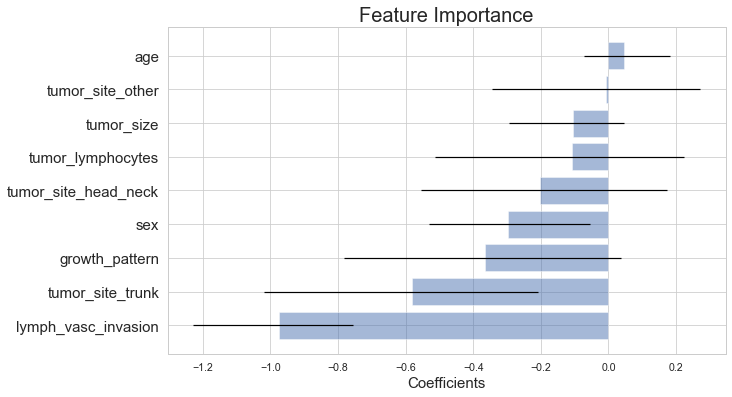

In [82]:
# get coefficients in order of importance
coefs_ordered = stats_summary.sort_values(by = 'mean', ascending = False, ignore_index = True)
n_features = coefs_ordered.shape[0]
error_values = [coefs_ordered.lower_error, coefs_ordered.upper_error]

# plot! 
filename = os.path.join(figure_path, "feature_importance_trainval_bootstrap_CI.png")
plt.figure(figsize = (10, 8))
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.barh(coefs_ordered['features'], coefs_ordered['mean'], xerr = error_values,
        align = 'center', alpha = 0.5, ecolor = "black")
ax.set_yticklabels(coefs_ordered['features'], size = 15)
ax.invert_yaxis()
ax.set_xlabel("Coefficients", size = 15)
ax.set_title("Feature Importance", size = 20)
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

### Evaluate final model on test set

,metrics,scores
0,precision,0.726
1,recall,0.765
2,roc_auc,0.493
3,accuracy,0.618
4,f1 score,0.745
5,pr_auc,0.727
6,brier_score,0.382


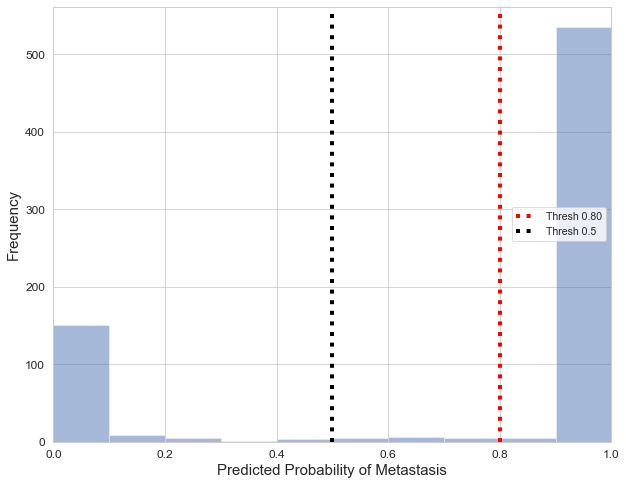

In [144]:

Isotonic_y_test_probs = Sigmoid.predict_proba(X_test)[:,1]
Isotonic_y_test_pred = Sigmoid.predict(X_test)
Isotonic_y_test_pred_adjusted=  Isotonic_y_test_probs > 0.5
Isotonic_scores = pd.DataFrame(get_scores(y_test, Isotonic_y_test_pred_adjusted))

#Isotonic_scores.to_csv("../model_output/TNM_outcome/full_features_final_calibrated_logreg_test_scores.csv")
display(Isotonic_scores)
custom_plots.plot_predprobs(Isotonic_y_test_probs, key_thresh,
                           filename = os.path.join(figure_path, "predprobs.png"))


../mcc_metastasis/modeling.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mets', 'No Mets'])
../mcc_metastasis/modeling.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mets', 'No Mets'])


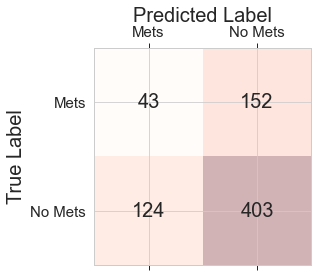

In [145]:
cm = confusion_matrix(y_test, Isotonic_y_test_pred_adjusted)
modeling.pretty_cm(cm, os.path.join(figure_path, "Test_confusion_matrix_adjusted.png"))
